In [40]:
import os
os.environ['DISPLAY'] = "localhost:12.0" #linux env variable for ase gui
from ase.build import nanotube
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np

1. calculate the radius of CNT

In [41]:
cnt_dict = {}
for n in range(12, 18):
    cnt_dict[f"{n}-0"] = nanotube(n, 0, length=20, bond=1.42, vacuum=10)  # length是六元环的长度，bond是C-C键长
# cnt_12.edit()
# view(cnt_dict['12-12'], viewer='ngl')

print(cnt_dict)

{'12-0': Atoms(symbols='C960', pbc=[False, False, True], cell=[29.394644377987337, 29.394644377987337, 85.19999999999999]), '13-0': Atoms(symbols='C1040', pbc=[False, False, True], cell=[30.17753140948628, 30.103325746608707, 85.19999999999999]), '14-0': Atoms(symbols='C1120', pbc=[False, False, True], cell=[30.960418440985226, 30.960418440985226, 85.19999999999999]), '15-0': Atoms(symbols='C1200', pbc=[False, False, True], cell=[31.74330547248417, 31.678974416383575, 85.19999999999999]), '16-0': Atoms(symbols='C1280', pbc=[False, False, True], cell=[32.52619250398311, 32.52619250398311, 85.19999999999999]), '17-0': Atoms(symbols='C1360', pbc=[False, False, True], cell=[33.309079535482056, 33.25230534850833, 85.19999999999997])}


In [42]:
cnt_length = cnt_dict['16-0'].cell.cellpar()[2]
print(cnt_length) 

85.19999999999999


In [43]:
def fit_circle(x, y):
    
    def calc_R(xc, yc):
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    from scipy.optimize import leastsq   
    center_estimate = x.mean(), y.mean()
    center_2, iter = leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(xc_2, yc_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    # residu2_2  = sum((Ri_2**2-R_2**2)**2)
    print(f'Fitted circle: center=({xc_2:.3f},{yc_2:.3f}), radius={R_2:.3f}, residu={residu_2:.3f}')
    return (xc_2, yc_2), R_2, residu_2

Fitted circle: center=(16.263,16.263), radius=6.263, residu=0.000


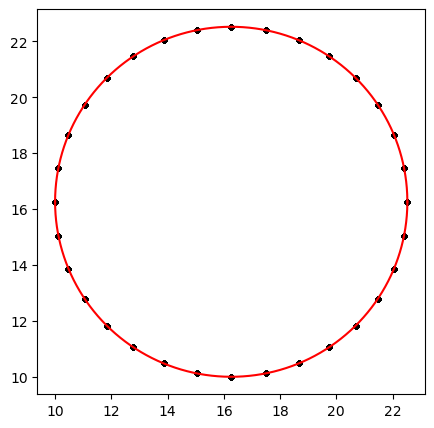

In [44]:
#test the fitting performance
x = cnt_dict['16-0'].get_positions()[:,0]
y = cnt_dict['16-0'].get_positions()[:,1]

plt.figure(figsize=(5,5))
plt.plot(x, y, '.', color='black')

center, r, residu = fit_circle(x, y)
x_fit = np.linspace(x.min(), x.max(), 1000000)
y_fit = np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
y_fit1 = -np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
plt.plot(x_fit, y_fit, '-', c='r')
plt.plot(x_fit, y_fit1, '-', c='r')

In [45]:
from ase.data import vdw_radii
c_vdw_r = vdw_radii[6]
print(c_vdw_r)

1.7


In [46]:
cnt_dict_fit = {}
for i in cnt_dict.keys():
    x = cnt_dict[i].get_positions()[:,0]
    y = cnt_dict[i].get_positions()[:,1]
    center, r, residu = fit_circle(x, y)
    cnt_dict_fit[i] = [*center, r, residu]
    
cnt_dict_fit

Fitted circle: center=(14.697,14.697), radius=4.697, residu=0.000
Fitted circle: center=(15.089,15.052), radius=5.089, residu=0.000
Fitted circle: center=(15.480,15.480), radius=5.480, residu=0.000
Fitted circle: center=(15.872,15.839), radius=5.872, residu=0.000
Fitted circle: center=(16.263,16.263), radius=6.263, residu=0.000
Fitted circle: center=(16.655,16.626), radius=6.655, residu=0.000


{'12-0': [np.float64(14.697322188993667),
  np.float64(14.697322188993667),
  np.float64(4.697322188993668),
  np.float64(1.6250534647552843e-27)],
 '13-0': [np.float64(15.088765704743139),
  np.float64(15.051662873304352),
  np.float64(5.08876570474314),
  np.float64(1.34106353887572e-27)],
 '14-0': [np.float64(15.480209220492611),
  np.float64(15.480209220492611),
  np.float64(5.480209220492613),
  np.float64(7.257520328033309e-28)],
 '15-0': [np.float64(15.871652736242083),
  np.float64(15.839487208191787),
  np.float64(5.871652736242085),
  np.float64(1.1201824854138368e-27)],
 '16-0': [np.float64(16.263096251991556),
  np.float64(16.263096251991556),
  np.float64(6.263096251991557),
  np.float64(1.3726179750845605e-27)],
 '17-0': [np.float64(16.654539767741028),
  np.float64(16.626152674254165),
  np.float64(6.654539767741027),
  np.float64(7.762391307374756e-27)]}

2.calculate the water numbers of different CNT with different water densities.

In [47]:
def calc_volume(r:float, l:float):
    """_summary_

    Args:
        r (float): radius of the nanotube
        l (float): length of the nanotube

    Returns:
        _type_: volume
    """
    return np.pi * r**2 * l

In [48]:
# def get_n_water(v:float, d:float):
#     """_summary_

#     Args:
#         v (float): volume of the nanotube, unit: A^3.
#         d (float): density of the filling water, unit: g/cm^3.

#     Returns:
#         _type_: number of water molecules
#     """
#     m0 = 1.008*2 + 15.999
#     NA = 6.022140857e23
#     u_a_cm = 1e-8 #1 A = 10^-8 cm
    
#     n_water =  d * v * u_a_cm**3 / (m0 / NA)

#     return n_water

In [49]:
def get_n_water(l: float, shape: float, len_density: float = 0.3400) -> int:
    return int(round(l * len_density * shape))

In [50]:
# v = calc_volume(4.068, 14.757)
get_n_water(38.33999999999999, 5)

65

In [67]:
n_water_dict = {}

for k, i in enumerate(cnt_dict_fit.keys(), start=2):  # k: 2,3,4,5,...
    shape = k
    n_water_dict[i] = get_n_water(l=38.34, shape=shape)  # 按你的 l 自己替换
    
    l = cnt_length
    n_water_dict[i] = get_n_water(l,shape)
n_water_dict  

{'12-0': 58, '13-0': 87, '14-0': 116, '15-0': 145, '16-0': 174, '17-0': 203}

3.fill water by Packmol

In [52]:
#generate pdb file
from ase.build import molecule
molecule('H2O', vacuum=3.0).write('H2O.pdb')

for i in cnt_dict.items():
    i[1].write(f'{i[0]}_test.pdb')
    print(f'{i[0]}_test.pdb')

12-0_test.pdb
13-0_test.pdb
14-0_test.pdb
15-0_test.pdb
16-0_test.pdb
17-0_test.pdb


In [65]:
Packmol_path = '/raid/hwding/anaconda3/envs/gpumd/bin/packmol'
import shutil
import os

def gen_packmol_inf(cnt_pdb,r_fit):
    from ase import io
    from random import randint
    tag = randint(0,10000)
   
    cnt = io.read(cnt_pdb)
    cnt_type = cnt_pdb.split('.')[0]
    cell = cnt.cell.cellpar()
    # v = calc_volume(r_fit, cell[2])
    shape=int(cnt_type.split('-')[0])-10
    print(shape)
    n_water = get_n_water(cell[2], shape=shape)
    
    ret = f'''tolerance 1.5
output {cnt_type}-d-{shape}.pdb
structure {cnt_type}.pdb
  number 1
  center
  fixed {cell[0]/2} {cell[1]/2} {cell[2]/2} 0 0 0
end structure

structure H2O.pdb #need change to your system
  number  {n_water} 
  inside cylinder {cell[0]/2} {cell[1]/2} 2 0 0 1 {r_fit} {cell[2]} 
end structure
'''
    inp_file = f'packmol-{cnt_type.split("/")[-1]}-{tag}.inp'
    with open(inp_file, 'w') as f_:
        f_.write(ret)
    return inp_file

def run_packmol(inp_file):
    from os import popen
    ret_mag = popen(f'{Packmol_path} < {inp_file}').read()
    if not 'Success!' in ret_mag:
        print (ret_mag)
        raise Exception(f'Packmol failed: {inp_file}')
    else:
        print (f'Packmol finished: {inp_file}')
    return None

def solvate_cnt(cnt_pdb, shape,r_fit):
#only support when alpha=beta=gamma=90
    inp_file = gen_packmol_inf(cnt_pdb, r_fit)
    run_packmol(inp_file)
    
    
    from ase import io
    # cnt_solv = io.read(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    cnt = io.read(cnt_pdb)
    cell_vect = cnt.cell.cellpar()
    with open (f'{cnt_pdb.split(".")[0]}-d-{shape}.pdb', 'r') as f_:
        lines = f_.readlines()
        lines[4] = f'CRYST1{cell_vect[0]:>9}{cell_vect[1]:>9}{cell_vect[2]:>9}\
{cell_vect[3]:>7}{cell_vect[4]:>7}{cell_vect[5]:>7}\n'
    with open (f'{cnt_pdb.split(".")[0]}-d-{shape}_lim_in.pdb', 'w') as f_:
        f_.writelines(lines)
    
    fname = f'{cnt_pdb.split(".")[0]}-d-{shape}_lim_in.pdb'
    src = fname                           # 源文件：当前目录下的那个 pdb
    dst = os.path.join('test', fname)     # 目标文件：test/同名 pdb

    shutil.copy(src, dst)
    # the following will remove the CONECT part of pdb file
    # cnt_solv.set_pbc([True, True, True])
    # cnt_solv.set_cell(cell_vect[0:3])
    # cnt_solv.center()
    # cnt_solv.write(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    
    from os import remove
    remove(inp_file)
    return None

In [66]:
os.chdir('/raid/hwding/model-build/model-build')

for i in cnt_dict_fit.items():
    print(i[0])

    shape = int(i[0].split("-")[0]) - 10
    print(i,shape)
    solvate_cnt(f'{i[0]}_test.pdb', shape,i[1][2])

# import glob
# from vac_cnt.add_connect_part import add_connect_part
# _list = glob.glob("*-d*.pdb")
# for i in _list:
#     add_connect_part(i)
    
os.chdir('..')

12-0
('12-0', [np.float64(14.697322188993667), np.float64(14.697322188993667), np.float64(4.697322188993668), np.float64(1.6250534647552843e-27)]) 2
2
Packmol finished: packmol-12-0_test-4226.inp
13-0
('13-0', [np.float64(15.088765704743139), np.float64(15.051662873304352), np.float64(5.08876570474314), np.float64(1.34106353887572e-27)]) 3
3
Packmol finished: packmol-13-0_test-9970.inp
14-0
('14-0', [np.float64(15.480209220492611), np.float64(15.480209220492611), np.float64(5.480209220492613), np.float64(7.257520328033309e-28)]) 4
4
Packmol finished: packmol-14-0_test-553.inp
15-0
('15-0', [np.float64(15.871652736242083), np.float64(15.839487208191787), np.float64(5.871652736242085), np.float64(1.1201824854138368e-27)]) 5
5
Packmol finished: packmol-15-0_test-4792.inp
16-0
('16-0', [np.float64(16.263096251991556), np.float64(16.263096251991556), np.float64(6.263096251991557), np.float64(1.3726179750845605e-27)]) 6
6
Packmol finished: packmol-16-0_test-8804.inp
17-0
('17-0', [np.float64

4.pre-optimize  

In [71]:
from ase.io import read, write
from ase.constraints import FixAtoms
os.chdir('/raid/hwding/model-build/model-build')
cnt_solv = read('6-6-d-0.5.pdb')
cnt_solv.set_constraint(FixAtoms(indices=[atom.index for atom in cnt_solv if atom.symbol == 'C']))
# cnt_solv._get_constraints()

FileNotFoundError: [Errno 2] No such file or directory: '6-6-d-0.5.pdb'

- method1: xtb  
can not optimze to the right state

In [7]:
# from xtb.ase.calculator import XTB
# cnt_solv.calc = XTB(method = 'GFN1-xTB', max_iterations=250)
# os.environ['OMP_NUM_THREADS'] = '12'
# os.environ['OMP_STACKSIZE'] = '30G'
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-xtb.pdb')

- method2: cp2k  
can not optimze to the right state

In [4]:
os.environ['CP2K_DATA_DIR'] = ''
cp2k_command = 'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;\
module load intel/impi/2018.4.274;\
mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

# cp2k_command = 'pwd_path=`pwd`;ssh node5 "cd ${pwd_path};module load gcc/9.3.0;\
# source /opt/intel/compilers_and_libraries_2018.5.274/linux/mkl/bin/mklvars.sh intel64;\
# source /home/kwwan/software/cp2k-7.1/cp2k-7.1/tools/toolchain/install/setup;\
# export PATH=$PATH:/home/kwwan/software/cp2k-7.1/cp2k-7.1/exe/local;\
# mpirun -n 96 cp2k_shell.popt"'
# os.environ['CP2K_DATA_DIR'] = '/home/kwwan/software/cp2k-7.1/cp2k-7.1/data'
os.environ['ASE_CP2K_COMMAND'] = cp2k_command
cp2k_command

'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;module load intel/impi/2018.4.274;mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

In [29]:
# from ase.calculators.cp2k import CP2K
# cnt_solv.set_calculator(CP2K())
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-cp2k.pdb')

- method3: vasp  
can not optimze to the right state

In [69]:
from glob import glob
cnt_pdb_list = glob('*-*-d-*.pdb')

In [37]:
path = '/home/kwwan/work/cnt/model-build/vasp-opt'
for i in cnt_pdb_list:
    tag = '.'.join(i.split('.')[:-1])
    if not os.path.exists(f'{path}/{tag}'):
        os.mkdir(f'{path}/{tag}')
    tmp = read(i)
    tmp.set_constraint(FixAtoms(indices=[atom.index for atom in tmp if atom.symbol == 'C']))
    tmp.write(f'{path}/{tag}/POSCAR', format='vasp', sort=True)

- 2 step method  
(1)lammps pre-opt

In [77]:
import os
from glob import glob
from gen_lmp_data.gen_lmp_data_vmd import gen_lmp_data

workdir = "/raid/hwding/cp2k/lmp-pre-2"
os.chdir(workdir)

# 1) 先从 pdb 生成 data（如果 gen_lmp_data 输出在同目录）
pdb_list = glob(os.path.join(workdir, "*-d*.pdb"))
for pdb in pdb_list:
    gen_lmp_data(pdb)

# 2) 收集生成的 .data
data_list = sorted(glob(os.path.join(workdir, "*-d*.data")))

# 3) 按文件名建目录并复制/链接
for path in data_list:
    base = os.path.basename(path)                 # e.g. xxx-d1.data
    i_ = os.path.splitext(base)[0]                # e.g. xxx-d1
    d = os.path.join(workdir, i_)

    os.makedirs(d, exist_ok=True)

    os.system(f'cp "{path}" "{d}/lmp.data"')
    os.system(f'ln -sf ../input.lammps "{d}/input.lammps"')
    os.system(f'ln -sf ../lmp.slurm "{d}/lmp.slurm"')

/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no versio

(2)cp2k opt

In [24]:
def gen_cp2k_input(file, work_dir):
    from ase.io import read
    traj = read(file, index=':')
    if file.split('/')[-1] == 'traj.dump':
        conv_dict = {1:'C', 2:'H', 3:'O'}
        traj[-1].set_chemical_symbols([conv_dict[i] for i in traj[-1].get_atomic_numbers()])
    traj[-1].write(f'{work_dir}/cp2k.cif')

    atom_type = traj[-1].get_chemical_symbols()
    atom_pos = traj[-1].get_positions()
    with open(f'{work_dir}/cp2k.xyz', 'w') as f:
        f.write(f'{len(atom_type)}\n\n')
        for i in range(0, len(atom_type)):
            f.write(f'{atom_type[i]:<8}{atom_pos[i,0]:<17}{atom_pos[i,1]:<17}{atom_pos[i,2]:<17}{i+1}\n')

    _list = traj[-1].get_chemical_symbols()
    ret = []
    for i in range(len(_list)):
        if _list[i] == 'C':
            if i > 1 and _list[i-1] == 'C':
                ret[-1] = f'..{i+1}'
            else:
                ret.append(f' {i+1}')
    return ''.join(ret)


In [29]:
from glob import glob
lmp_list = glob('/home/kwwan/work/cnt/model-build/lmp-pre-opt-6/*d-0.4*-lmp/traj.dump')

In [30]:
import os
work_dir = '/home/kwwan/work/cnt/aimd/1'
for i in lmp_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    # os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    # os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    # os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')

5.test parameters  
CUTOFF:850 RELCUTOFF:70


6.cp2k aimd

In [5]:
work_dir = '/home/kwwan/work/cnt/model-build/aimd'
pdb_list = glob('/home/kwwan/work/cnt/model-build/cp2k-opt-6/*d-*/cp2k-pos-1-new.pdb')

In [11]:
# ! rm -rf !(cp2k.sh|cp2k.inp)
for i in pdb_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')